<a href="https://colab.research.google.com/github/odartsi/AnomalyDetection/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Another Brain test
---
## Description:

We want to perform **unsupervised anomaly detection on MNIST digit**.
During training some digit classes (i.e. the anomalous one) are held out.
The model computes a score of normality (the higher the more normal).

**At test time the model computes a score for all digit categories.** 
The performance of the model is evaluated with the ROC AUC. --> https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=the%20multiclass%20model%3F-,What%20is%20the%20AUC%20%2D%20ROC%20Curve%3F,capable%20of%20distinguishing%20between%20classes.

A simple model training and evaluation is provided.

The objective is to implement a better model. The model is trained and evaluated 10 times.
**For each round a new digit class is chosen to be the anomalous one.**

An average AUC (over the 10 digits) of **0.8** is reachable.

The demonstration model is not a neural net trained with gradient descent
but you are not restricted to any kind of solution.

Make sure your solution can be evaluated. 





Steps to follow:


[x] Load the dataset

[x] Have a loop where each time the dataset will be split accordingly

[x] Visualise the training and testing dataset

[] Create the autoencoder 

[] Evaluate the model










# Import necessary libraries

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import layers, losses
from keras import backend as K
from keras import metrics
import tensorflow as tf

import matplotlib.pyplot as plt

# Load dataset and constract train and test

In [66]:
def remove_anomalies(anomaly, x, y):
    idx = (y != anomaly).nonzero()
    y[idx] = np.ones(len(idx))
    return x[idx], y[idx]

def testing_cleanup(anomaly,x,y):
    y = np.array([1 if y != anomaly else 0 for y in y])
    return x,y

In [117]:
for i in range(10):
  (x_train, y_train), (x_test, y_test) =  tf.keras.datasets.mnist.load_data()
  (x_train, y_train) = remove_anomalies(i, x_train, y_train)
  (x_test, y_test) = testing_cleanup(i, x_test, y_test)
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  # print(y_train.shape)
  # print(y_test.shape)

In [118]:
train_ds = (x_train, y_train)

# Visualisation of the data in order to be sure

Training dataset

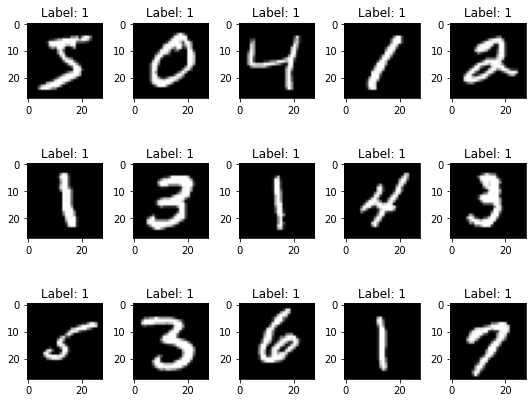

In [68]:
rows = 3
cols = 5
num=15
# plot images
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols,2*rows))
for i in range(num):
    ax = axes[i//cols, i%cols]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

Testing dataset

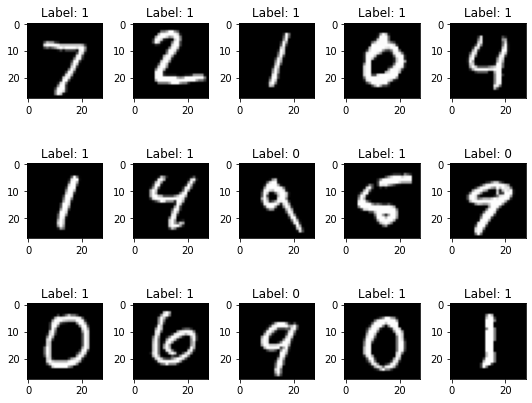

In [69]:
rows = 3
cols = 5
num=15
# plot images
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols,2*rows))
for i in range(num):
    ax = axes[i//cols, i%cols]
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_test[i]))
plt.tight_layout()
plt.show()

# Autoencoder

In [119]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [120]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [121]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0255 - val_loss: 0.0102
Epoch 2/10
1690/1690 [==============================] - 4s 3ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 3/10
1690/1690 [==============================] - 6s 3ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 4/10
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 5/10
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/10
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/10
1690/1690 [==============================] - 4s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/10
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/10
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/10
1690/1690 [==============================] - 4s 2ms/step - loss: 0.004

In [122]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

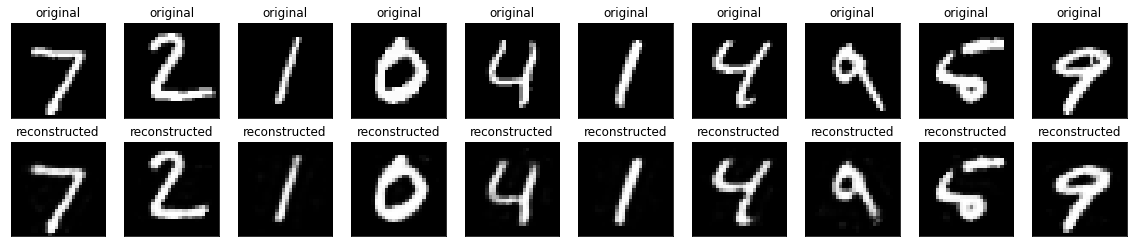

In [123]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Anomaly detection

In [104]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(28, activation="sigmoid")#,
      #layers.Reshape((28, 28))
      ])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [105]:
autoencoder.compile(optimizer='adam', loss='mae')

In [106]:
history = autoencoder.fit(x_train, x_train,
                epochs=20, 
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
106/106 [==============================] - 3s 24ms/step - loss: 33.6967 - val_loss: 33.8149
Epoch 2/20
106/106 [==============================] - 2s 21ms/step - loss: 33.4971 - val_loss: 33.6942
Epoch 3/20
106/106 [==============================] - 2s 21ms/step - loss: 33.4443 - val_loss: 33.6861
Epoch 4/20
106/106 [==============================] - 2s 21ms/step - loss: 33.4400 - val_loss: 33.6837
Epoch 5/20
106/106 [==============================] - 3s 27ms/step - loss: 33.4382 - val_loss: 33.6822
Epoch 6/20
106/106 [==============================] - 2s 22ms/step - loss: 33.4368 - val_loss: 33.6810
Epoch 7/20
106/106 [==============================] - 2s 21ms/step - loss: 33.4356 - val_loss: 33.6796
Epoch 8/20
106/106 [==============================] - 2s 21ms/step - loss: 33.4345 - val_loss: 33.6789
Epoch 9/20
106/106 [==============================] - 2s 20ms/step - loss: 33.4338 - val_loss: 33.6784
Epoch 10/20
106/106 [==============================] - 2s 21ms/step - los

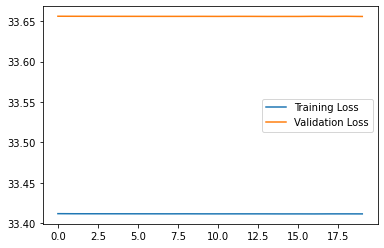

In [92]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

ValueError: ignored

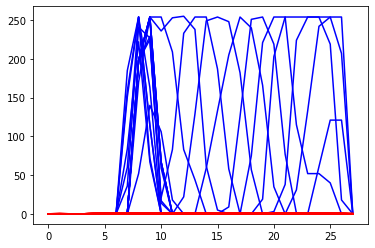

In [114]:
encoded_data = autoencoder.encoder(x_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(x_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], x_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()